In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import seaborn
from sklearn.linear_model import Perceptron

Данные о качестве (вкусе) яблок. В основном предоставлены Американскими агрокультурными компаниями.

Загрузка данных

In [2]:
data = pandas.read_csv('data/apple_quality.csv')
data = data.drop(['A_id'], axis=1)
data = data.dropna()

Преобразование целевой переменной

In [3]:
le = LabelEncoder()
data['Quality'] = data['Quality'].apply(lambda x: 1 if x == 'good' else 0)
y = le.fit_transform(data['Quality'])
x = data.drop(['Quality'], axis=1)

Разделение данных

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y) # Выделяет 20% данных в качестве тестовых, 80% в качестве данных для обучения, сохраняет соотношение "хороших" и "плохих" яблок (за счет stratify=y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Персептрон

In [11]:
mlp = MLPClassifier(random_state=42, early_stopping=True, solver='lbfgs')
params_mlp = {
    'hidden_layer_sizes': [(60,), (100,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter': [1000, 1500, 2000],
}

# Алгоритм машинного обучения, который представляет собой искусственную нейронную сеть с несколькими слоями
# Входной слой: получает данные о яблоке (размер, вес, сладость...)
# Скрытые слои: анализируют данные, комбинируют признаки и передают сигналы дальше
# Выходной слой: выдает итоговый ответ (вероятность того, что яблоко хорошее)
# Сеть учится на ошибках: корректирует «веса» связей между нейронами (метод обратного распространения ошибки)

# identity - нейрон просто передает входной сигнал без изменений, не может моделировать сложные нелинейные зависимости
# logistic - сжимает вход в диапазон от 0 до 1, может вызывать проблему исчезающих градиентов (нейрон перестает обучаться, если вход очень большой/маленький)
# tanh - сжимает вход в диапазон от -1 до 1, страдает от проблемы исчезающих градиентов
# relu - если вход положительный - передает его дальше, если вход отрицательный - блокирует (выход = 0)

grid_mlp = GridSearchCV(mlp, params_mlp, cv=5, scoring='accuracy') # 1/5 данных (cv) будет выполнять роль тестовых, 4/5 обучение
grid_mlp.fit(x_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, random_state=42,
                                     solver='lbfgs'),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(60,), (100,), (200,)],
                         'max_iter': [1000, 1500, 2000]},
             scoring='accuracy')

Оценка методов

Perceptron:
Accuracy: 0.932

              precision    recall  f1-score   support

         bad       0.93      0.93      0.93       399
        good       0.93      0.93      0.93       401

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



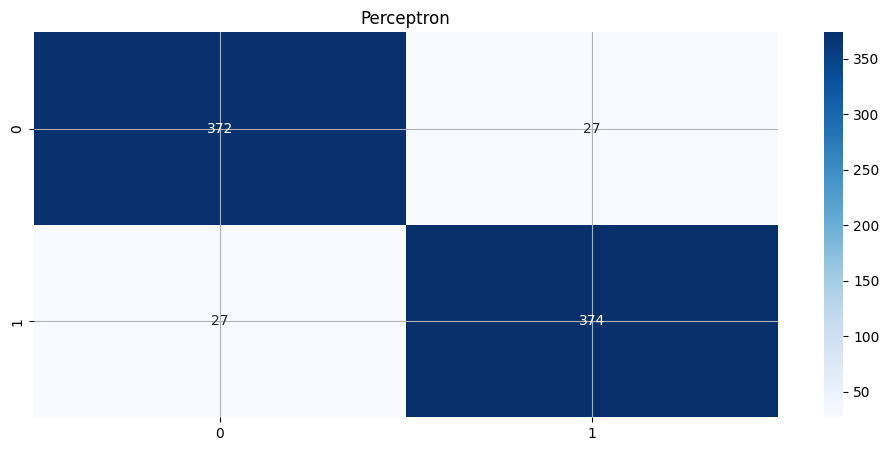

In [12]:
def evaluate_model(name, model, x_test, plot_config):
    plt.subplot(plot_config)
    
    y_pred = model.predict(x_test)

    print(name + ":")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")

    print(classification_report(y_test, y_pred, target_names=["bad", "good"]))

    plt.title(name)
    
    cm = confusion_matrix(y_test, y_pred)
    seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.grid()

plt.figure(figsize=(12, 5))

evaluate_model("Perceptron", grid_mlp.best_estimator_, x_test_scaled, 111)

# precision - точность, сколько из определенных "плохими" яблок действительно плохие
# recall - полнота, сколько модель нашла действительно "плохих" яблок
# f1-score - общий показатель на основе precision и recall